## CRNN
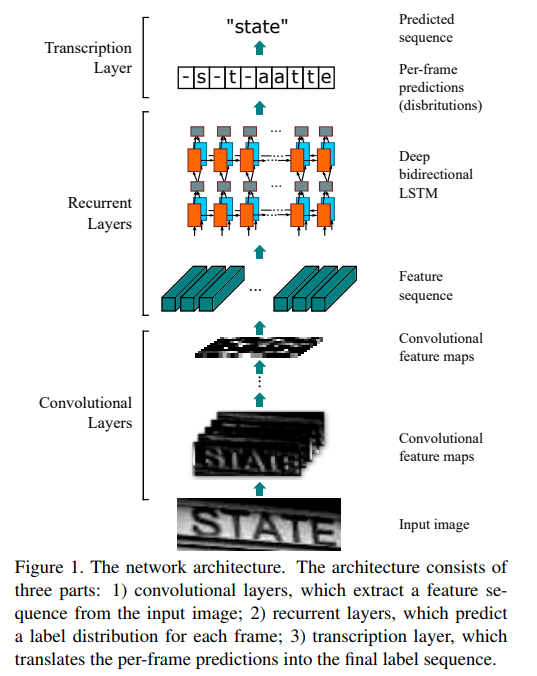
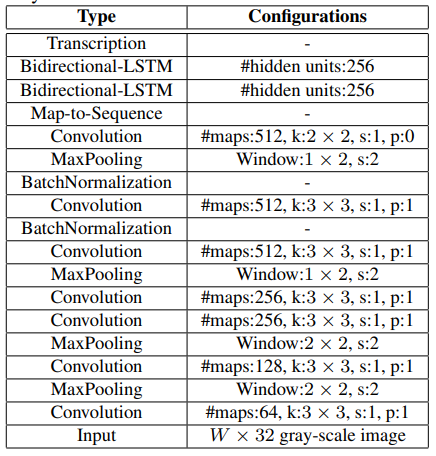

Q. CRNN 구조에서 Map-to-Sequence 가 하는 역할은 무엇일까요?<br>
CRNN의 Map-to-Sequence는 입력 이미지를 RNN 모델에 적용하기 전에, 이미지의 특징 맵을 시퀀스 데이터로 변환하는 방법입니다.<br>
<br>
기존의 CNN 모델은 이미지를 입력받아 컨볼루션 레이어와 풀링 레이어 등을 통해 다양한 크기의 특징 맵(feature map)을 추출합니다. 이러한 특징 맵은 각각이 이미지의 일부분에 대한 정보를 담고 있으며, 이들을 RNN에 직접 입력하면 연산 비용이 매우 높아지는 문제가 있습니다.<br>
<br>
이를 해결하기 위해, CRNN에서는 특징 맵을 시퀀스 데이터로 변환하여 RNN에 입력합니다. 이때, 특징 맵의 각 행을 시간 축으로 간주하여 시퀀스 데이터로 변환하는 방법이 많이 사용됩니다. 이렇게 변환된 시퀀스 데이터는 RNN의 입력으로 사용되어, 이미지 내에 있는 패턴이나 텍스트 등의 시퀀스 정보를 추출하는 데 사용됩니다.

In [2]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


 문자가 없는 경우를 위해서 공백을 추가할 경우 class의 수는 37개가 됩니다.

In [24]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf
import keras_ocr
import cv2
from PIL import Image , ImageDraw

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/GoingDeeper/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/aiffel/aiffel/GoingDeeper/ocr/data/MJ/MJ_train


## Input Image

### 데이터셋 안 이미지가 어떻게 생겼는지 확인

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


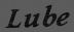

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


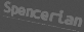

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


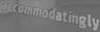

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


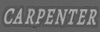

In [4]:
from IPython.display import display

# env에 데이터를 불러올게요
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적이에요
env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

# 불러온 데이터를 txn(transaction)이라는 변수를 통해 엽니다
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에 
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

In [10]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

print("@,@")

@,@


## Encode

In [11]:
class LabelConverter(object):
    def __init__(self, character):
        self.character = "-" + character
        self.label_map = dict()
        for i, char in enumerate(self.character):
            self.label_map[char] = i

    def encode(self, text):
        encoded_label = []
        text = text.upper()
        separator ='-'
        new_text = ""
        new_text += text[0]
        for i in range(1,len(text)):
            if text[i-1] == text[i]:
                new_text += separator + text[i]
            else:
                new_text += text[i]
        
        for t in new_text:
            encoded_label.append(self.label_map[t])

        return np.array(encoded_label)

    def decode(self, encoded_label):
        target_characters = list(self.character)
        decoded_label = ""
        for encode in encoded_label:
            decoded_label += self.character[encode]
        return decoded_label

## CTC Loss Function

In [13]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
print("@,@")

@,@


## Build CRNN Model

In [12]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model
print("@,@")

@,@


## Train & Inference

In [14]:
# 데이터셋과 모델을 준비합니다
label_converter = LabelConverter(TARGET_CHARACTERS)
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()

# 모델을 컴파일 합니다`
optimizer = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

In [15]:
# 훈련이 빨리 끝날 수 있도록 ModelCheckPoint와 EarlyStopping을 사용합니다
# ModelCheckPoint의 경우 'val_loss'를 모니터링하고 weight만 저장하는 옵션으로 지정해주세요.
# EarlyStopping도 'val_loss'를 모니터링해주세요.
# (EarlyStopping을 사용하지 않는 경우, model.fit()의 epoch 옵션을 20 정도로 설정해주세요.

checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'
# Model Checkpoint 설정
ckp = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                     monitor = 'val_loss',
                     save_best_only = True,
                     save_weights_only = True,
                     mode = 'min',
                     verbose = 1)

# earlystop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
#                                             patience = 3,
#                                             mode = 'min',
#                                             verbose = 1)

history = model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=20,
          validation_data=val_set,
          validation_steps=len(val_set),
          # ModelCheckPoint와 EarlyStopping을 활용하는 경우 바로 아래 callbacks 옵션에 주석을 풀어주세요.
          callbacks=[ckp]#, earlystop]
)

Epoch 1/20
565/565 [==============================] - 106s 156ms/step - loss: 25.1651 - val_loss: 23.8964

Epoch 00001: val_loss improved from inf to 23.89640, saving model to /aiffel/aiffel/GoingDeeper/ocr/model_checkpoint.hdf5
Epoch 2/20
565/565 [==============================] - 81s 144ms/step - loss: 12.9746 - val_loss: 8.8108

Epoch 00002: val_loss improved from 23.89640 to 8.81084, saving model to /aiffel/aiffel/GoingDeeper/ocr/model_checkpoint.hdf5
Epoch 3/20
565/565 [==============================] - 82s 144ms/step - loss: 6.5319 - val_loss: 6.0192

Epoch 00003: val_loss improved from 8.81084 to 6.01918, saving model to /aiffel/aiffel/GoingDeeper/ocr/model_checkpoint.hdf5
Epoch 4/20
565/565 [==============================] - 81s 143ms/step - loss: 4.7974 - val_loss: 5.0251

Epoch 00004: val_loss improved from 6.01918 to 5.02506, saving model to /aiffel/aiffel/GoingDeeper/ocr/model_checkpoint.hdf5
Epoch 5/20
565/565 [==============================] - 81s 143ms/step - loss: 3.819

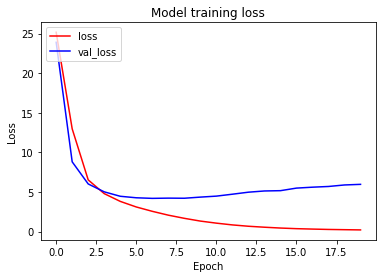

In [17]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

In [18]:
# 다음은 학습된 모델의 가중치가 저장된 경로입니다
checkpoint_path = HOME_DIR + '/data/model_checkpoint.hdf5'

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

In [71]:
from IPython.display import display

# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
# 코드 하나하나를 이해하기는 조금 어려울 수 있습니다
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        if index == -1:
            break
        text += chars[index]
    results.append(text)
    return results

# 모델과 데이터셋이 주어지면 inference를 수행합니다
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해줍니다
def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

## Keras OCR을 이용하기 위한 준비

In [35]:
from keras_ocr.detection import Detector
HOME_DIR = os.getenv('HOME')+'/aiffel/GoingDeeper/ocr'
SAMPLE_IMG_PATH = HOME_DIR + '/data/sample.jpg'

detector = Detector()
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


## Keras OCR을 이용해 이미지 속 텍스트를 발견하고 텍스트만 들어있는 이미지리스트 만들기

In [36]:
def detect_text(img_path):
    # TODO

    # 배치 크기를 위해서 dimension을 확장해주고 kera-ocr의 입력 차원에 맞게 H,W,C로 변경합니다.

    # 배치의 첫 번째 결과만 가져옵니다.

    # 시각화를 위해서 x와 y좌표를 변경해줍니다. (앞선 h dimension으로 인해 y,x로 표기됨)
    
    # 이미지 불러오기
    img = keras_ocr.tools.read(img_path)

    # 이미지에서 문자 감지
    boxes = detector.detect([img])[0]
    
    # PIL 이미지 생성 및 드로잉 객체 생성
    img_pil = Image.open(img_path)
    img_draw = ImageDraw.Draw(img_pil)
    
    
    # 시각화를 위해서 x와 y좌표를 변경해줍니다. (앞선 H dimension으로 인해 y,x로 표기됨)
    cropped_imgs = []
    for box in boxes:
        polygon = [tuple(pair) for pair in box]
        img_draw.polygon(polygon, outline='red')
        x_min = box[:,0].min() - 5
        x_max = box[:,0].max() + 5
        y_min = box[:,1].min() - 5
        y_max = box[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_pil.crop(word_box))

    # 결과 이미지 반환
    result_img = np.array(img_pil)
    
    return result_img, cropped_imgs

#### 이미지 속 텍스트가 잘 탐지되었는지, 텍스트만을 가진 이미지가 잘 크롭이 되었는지 확인

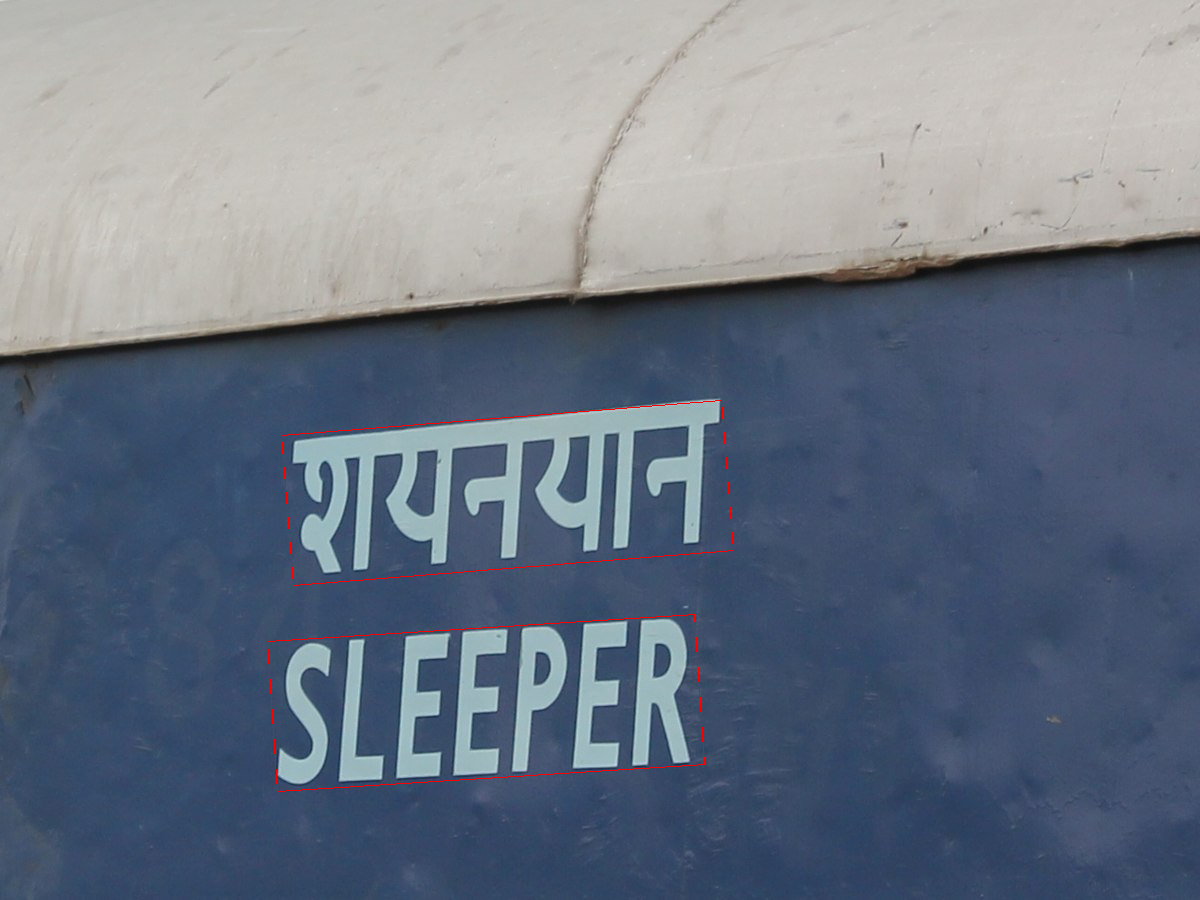

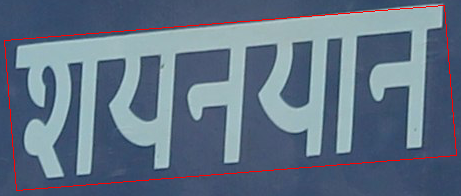

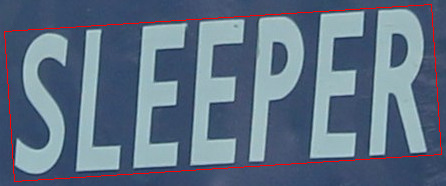

In [37]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(Image.fromarray(img_pil.astype(np.uint8)))
for img in cropped_img:
    display(Image.fromarray(np.array(img).astype(np.uint8)))

## Keras-OCR을 이용해 Text Recognizer 만들기

In [93]:
def recognize_img(pil_img, pipeline, input_img_size=(100,32)):
    # TODO: 잘려진 단어 이미지를 인식하는 코드를 작성하세요!    
    # 이미지 크기 조정
    pil_img = pil_img.resize(input_img_size, Image.ANTIALIAS)
    img_array = np.array(pil_img)

    # 이미지 인식
    prediction_groups = pipeline.recognize([img_array])
    
    # 배치의 첫 번째 결과 가져오기
    ocr_result = prediction_groups[0]
    
    # 인식된 텍스트 반환
    recognized_text = ' '.join([text for text, _ in ocr_result])
    
    return recognized_text

### CRNN을 이용한 test set 이미지 속 텍스트 추출하기

Result: 	 SLINKING


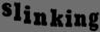

Result: 	 ALEPPO


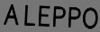

Result: 	 FWANDA


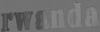

Result: 	 NATHANS


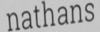

Result: 	 HALLE


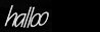

Result: 	 HURLS


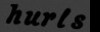

Result: 	 DOWNSIZE


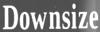

Result: 	 ROBOTIC


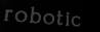

Result: 	 SLOPPY


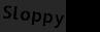

Result: 	 SHERMITE


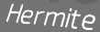

In [72]:
check_inference(model_pred, test_set, index=10)

### Keras-OCR을 이용해 test set 이미지 속 텍스트 추출하기

Result: 	 SLINKING


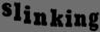

Result: 	 ALEPPO


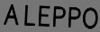

Result: 	 RWANDA


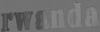

Result: 	 NATHANS


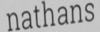

Result: 	 HALLO


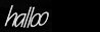

Result: 	 HURLS


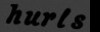

Result: 	 DOWNSIZE


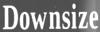

Result: 	 ROBOTIC


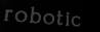

Result: 	 SLOPPY


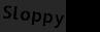

Result: 	 HERMITE


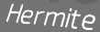

In [95]:
for i in range(10):
    img = test_set[i][0]['input_image'][0:1,:,:,:]
    img = img[0].transpose(1,0,2)
    img = Image.fromarray(img.astype(np.uint8))
    result = recognize_img(img, pipeline)
    print("Result: \t", result.upper())
    display(img)

### CRNN을 이용한 sample img 텍스트 추출하기

Result: 	 SVRUPRUA


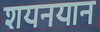

Result: 	 SLEEPER


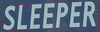

In [69]:
def check_inference_sample (model, imgs, index = 5):
    for img in imgs:
        # 이미지 불러오기
        pil_img = img.resize((100,32), Image.ANTIALIAS)
        img_array = np.array(pil_img)
        # (H,W,C)를 (W, H, C) 로 변환시켜야함.
        img_array = img_array.transpose(1,0,2)
        img_array = np.expand_dims(img_array, axis = 0)
        output = model.predict(img_array)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img_array[0].transpose(1,0,2).astype(np.uint8)))


check_inference_sample(model_pred, cropped_img, index=2)

### Keras-OCR을 이용한 Sample Img 텍스트 추출하기

<class 'PIL.Image.Image'>
(32, 100, 3)


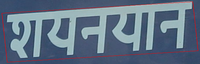

result: ptrt
<class 'PIL.Image.Image'>
(32, 100, 3)


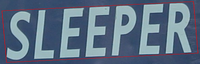

result: sleeper


In [89]:
for _img in cropped_img:
    print(type(_img))
    text = recognize_img(_img, pipeline)
    img = _img.resize((200,64), Image.ANTIALIAS)
    img = np.array(img)
    display(Image.fromarray(img.astype(np.uint8)))
    print(f'result: {text}')

CRNN 모델 이용시: <br>
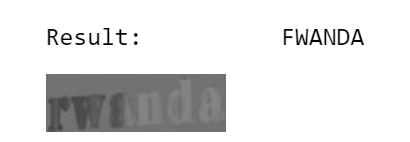<br>
Keras-OCR 이용시: <br>
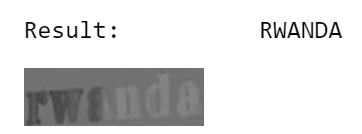<br>
CRNN을 사용한 결과에서는 R을 F로 인식하는 문제가 발견되었습니다.<br>
<br><br>
CRNN 모델 이용시: <br>
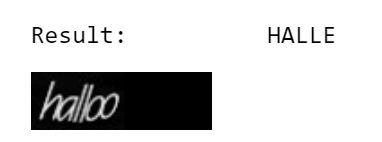<br>
Keras-OCR 이용시: <br>
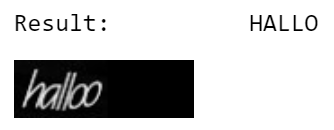<br>
CRNN과 Keras OCR 모두 제대로 인식하지는 못했다. 하지만 CRNN은 O를 E로 인식하는 문제와 연속되는 문자를 인식하지 못했다는 문제점이 보이고  Keras OCR은 연속되는 문자를 인식하지 못 했다는 문제점이 보인다.<br> 
<br>
CRNN 모델 이용시: <br>
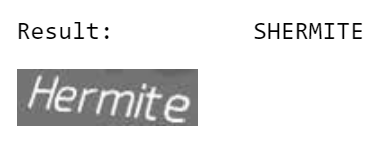<br>
Keras-OCR 이용시: <br>
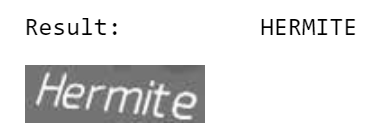<br>
CRNN에서 HERMITE 앞에 S를 잘못 인식했다.<br>
<br>
10개의 test set 데이터 결과만으로는 Keras-OCR의 성능이더 좋아보이는 것 같다.

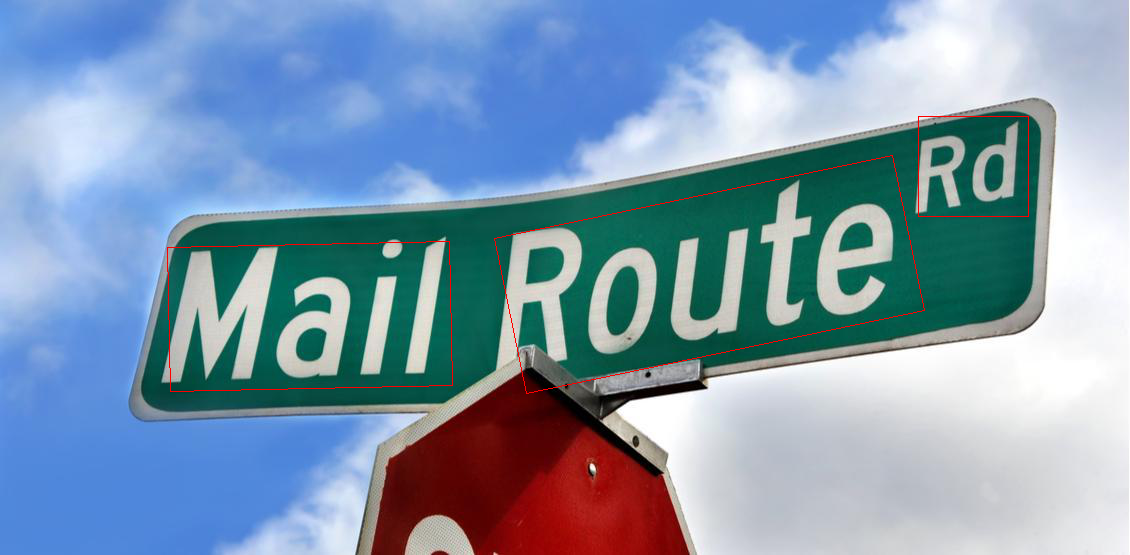

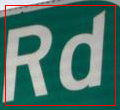

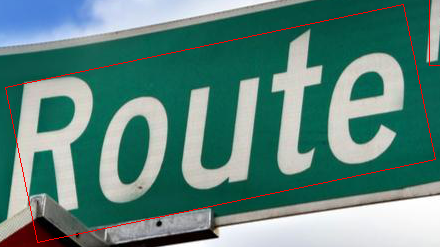

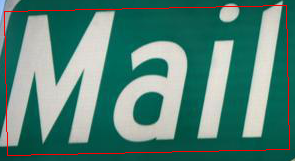

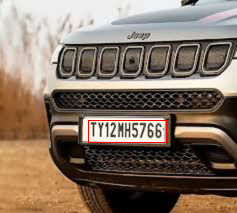

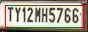

ResourceExhaustedError:  OOM when allocating tensor with shape[1,64,2264,4864] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_14/basenet.slice1.1/FusedBatchNormV3 (defined at opt/conda/lib/python3.9/site-packages/keras_ocr/detection.py:780) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_89180]

Function call stack:
predict_function


In [98]:
cropped_sets = []
for i in range(1, 9):
    IMG_PATH = HOME_DIR + f'/images/image{i}.jpg'
    img_pil, cropped_img = detect_text(IMG_PATH)
    cropped_sets.extend(cropped_img)
    display(Image.fromarray(img_pil.astype(np.uint8)))
    for img in cropped_img:
        display(Image.fromarray(np.array(img).astype(np.uint8)))

# 회고
#### 1. 아쉬운점
더 많은 실험을 해보지 못 한것이 아쉬웠고, 여태까지 한 실험에서도 볼 수 있듯이 CRNN에서 문제점을 확인할 수가 있었습니다. 그 문제점을 해결할 수 있는 모델을 만들지 못한 것이 아쉽습니다.
#### 2. 배운점
CRNN의 구조를 배우면서 CNN으로 텍스트를 탐지하고 RNN으로 텍스트를 인식할 수 있는 모델 구조에 대해서 배울 수 있었습니다.
#### 3. 느낀점
다양한 방법으로 OCR을 만들 수 있다는 것에 흥미가 돋았습니다. 비록 모든 방법을 다 써볼 수 없었지만 CRNN과 Keras-OCR을 구조를 배우며 만들어볼 수 있어서 재밌었습니다.